# Student Notebook - Lecture 12

This notebook provides an introduction to evaluating the fairness of your predictive model. This is especially relevant because in modeling human data, treating different socio-demographic groups equitably is especially important. It is also crucial to consider the context of your downstream task and where these predictions will be used.
Below, you will find functions for computing three popular fairness metrics:
- demographic parity
- equalized odds
- predictive value parity

In [1]:
# Load standard imports for the rest of the notebook.
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

DATA_DIR = "./../../data/"

### Fairness Definition 1: Demographic Parity

**Demographic Parity** states that the proportion of each segment of a protected class (e.g. gender) should receive the positive outcome at equal rates. In other words, the probability of a positive outcome (denoted as PPP) should be the same independent of the value of the protected attribute.

We first write a function `compute_ppp` that calculates the PPP for a given population.

In [2]:
# For demographic parity, we compare the difference between the PPPs of the sensitive attributes.
def compute_ppp(df):
    """Calculate PPP for subgroup of population"""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    # Total population
    N = TP + FP + FN + TN 
    
    # predicted as positive
    PPP = (TP + FP) / N 
    
    return PPP

### Fairness Definition 2: Equalized Odds

Our second definition of fairness is called **equalized odds**. This definition requires that the true positive rates (TPR) as well as the false positive rates (FPR) are equal accross values of the sensitive attribute. That is a similar percentage of the groups should both rightfully and wrongfully benefit.
An advantage of equalized odds is that it does not matter how we define our target variable. Suppose instead we had Y = 0 leads to a benefit. In this case the interpretations of TPR and FPR swap. TPR now captures the wrongful benefit and FPR now captures the rightful benefit. Equalized odds already uses both of these rates so the interpretation remains the same. In comparison, the interpretation of equal opportunity changes as it only considers TPR.

In [3]:
def equalized_odds(df):
    """Calculate FPR and TPR for subgroup of population"""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel() 
    
    # True positive rate
    TPR = TP / (TP + FN) 
    
    # False positive rate
    FPR = FP / (FP + TN)
    
    return [TPR, FPR]

### Fairness Definition 3: Predictive Value Parity

Predictive value-parity equalizes the probability of a positive outcome, given a positive prediction (PPV) and the probability of a negative outcome given a negative prediction (NPV).

In [4]:
def predictive_value_parity(df):
    """Calculate predictive value parity scores"""
    
    # Confusion Matrix
    cm = confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    # Positive Predictive Value
    PPV = TP / (FP + TP) 
    
    # Negative Predictive Value
    NPV = TN / (FN + TN) 
    
    return [PPV, NPV]

## 2 - Fairness Evaluation Example

We will evaluate fairness of a model predicting whether a student will pass or fail a flipped classroom course. To this end, we use the same flipped classroom data set as in the previous lectures.
We will first load the data set.

In [5]:
# Load demographic data. The two attributes that are relevant to our analysis are "country_diploma" and "gender",
# although there are many other analyses that can be conducted.

demographics = pd.read_csv(DATA_DIR + 'demographics.csv', index_col=0).reset_index()
demographics

,index,gender,country_diploma,continent_diploma,year_diploma,title_diploma,avg_french_bac,rating_french,scale_french,rating_maths,scale_maths,rating_physics,scale_physics,grade
0,0,M,France,Europe,2018.0,Bacc. étranger,18.28,15.0,20.0,17.0,20.0,19.0,20,2.50
1,1,M,France,Europe,2018.0,Bacc. étranger,17.68,13.0,20.0,18.0,20.0,19.0,20,1.75
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.50
3,3,M,France,Europe,2018.0,Bacc. étranger,17.78,11.0,20.0,20.0,20.0,19.0,20,4.50
4,4,M,France,Europe,2018.0,Bacc. étranger,18.84,13.0,20.0,19.0,20.0,20.0,20,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,105,M,France,Europe,2018.0,Bacc. étranger,14.76,16.0,20.0,14.0,20.0,15.0,20.0,2.75
210,106,M,Suisse,Europe,2019.0,Mat. reconnue opt. physique et math,NaN,4.5,6.0,6.0,6.0,5.5,6.0,3.25
211,107,M,Suisse,Europe,2018.0,Mat. reconnue opt. physique et math,NaN,5.5,6.0,5.5,6.0,5.5,6.0,5.75
212,108,M,France,Europe,2018.0,Bacc. étranger,17.21,12.0,20.0,17.0,20.0,18.0,20.0,5.50


In [6]:
# We've run a BiLSTM model on the data using a 10-fold cross validation, generating predictions for all 214 students.
predictions = pd.read_csv(DATA_DIR + 'model_predictions.csv')

# convert predictions between [0, 1] to binary variable for pass / fail {0, 1}
y_pred = [1 if grade < 0.5 else 0 for grade in predictions['grade']]

In [7]:
# Load and process ground truth grades, which are between 0 to 6
# Recieving a score 4 or higher is passing, so we can convert these grades to a binary pass/fail variable {0, 1}
y = [1 if grade >= 4 else 0 for grade in demographics['grade']]

In [8]:
demographics.insert(0, 'y', y)
demographics.insert(1, 'y_pred', y_pred)

In [9]:
display(demographics)

,y,y_pred,index,gender,country_diploma,continent_diploma,year_diploma,title_diploma,avg_french_bac,rating_french,scale_french,rating_maths,scale_maths,rating_physics,scale_physics,grade
0,0,0,0,M,France,Europe,2018.0,Bacc. étranger,18.28,15.0,20.0,17.0,20.0,19.0,20,2.50
1,0,0,1,M,France,Europe,2018.0,Bacc. étranger,17.68,13.0,20.0,18.0,20.0,19.0,20,1.75
2,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.50
3,1,1,3,M,France,Europe,2018.0,Bacc. étranger,17.78,11.0,20.0,20.0,20.0,19.0,20,4.50
4,1,1,4,M,France,Europe,2018.0,Bacc. étranger,18.84,13.0,20.0,19.0,20.0,20.0,20,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,0,0,105,M,France,Europe,2018.0,Bacc. étranger,14.76,16.0,20.0,14.0,20.0,15.0,20.0,2.75
210,0,0,106,M,Suisse,Europe,2019.0,Mat. reconnue opt. physique et math,NaN,4.5,6.0,6.0,6.0,5.5,6.0,3.25
211,1,1,107,M,Suisse,Europe,2018.0,Mat. reconnue opt. physique et math,NaN,5.5,6.0,5.5,6.0,5.5,6.0,5.75
212,1,1,108,M,France,Europe,2018.0,Bacc. étranger,17.21,12.0,20.0,17.0,20.0,18.0,20.0,5.50


We first start by analyzing, whether our data set is imbalanced with respect to protected attributes. In the following, we will always focus on gender (the analysis could be conducted in exactly the same way for other protected attributes.

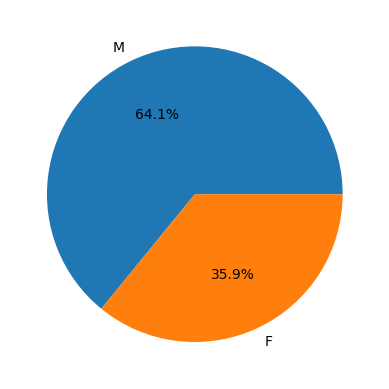

In [10]:
val_counts = demographics.gender.value_counts()/np.sum(demographics.gender.value_counts())
labels = val_counts.index.to_list()
plt.pie(val_counts, labels = labels,autopct='%1.1f%%')
plt.show()

We observe that the data set is imbalanced with only 35.9% of the students identifying as female.

Next, we also look at the prevalence, i.e. the proportion of positive cases to overall cases.

In [11]:
prev = demographics['y'].mean()
print(prev)

0.6261682242990654


In [12]:
prev_gender = demographics.groupby('gender')['y'].mean()
print(prev_gender)

gender
F    0.657143
M    0.568000
Name: y, dtype: float64


We observe that the pevalence is higher for female students.

## 3 - Your Task
Evaluate fairness of the model by computing one of the fairness metrics discussed in class.
Send us the following:
- Why did you choose this metric? Why do you think it is appropriate for the given use case?
- Is the classifier fair with respect to your selected metric? If not, what consequences might this have?

In [ ]:
# YOUR TURN: FILL IN CODE HERE

# Get PPP for males (in case of demographic parity)
ppp_m = compute_ppp(demographics[demographics['gender'] == 'M'])

# Get PPP for females (in case of demographic parity)
ppp_f = ''

# Print values
print(ppp_m, ppp_f)

In [ ]:
import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

npt_config = {
    'session_name': 'lecture-12',
    'session_owner': 'mlbd',
    'sender_name': input("Your name: "),
}

In [ ]:
# YOUR TURN: Why did you choose this metric? 
# Why do you think it is appropriate for the given use case?

argument = ''
send(argument, 1)

In [ ]:
# YOUR TURN: Discuss your results. Is the classifier fair with respect to your selected metric? 
# If not, what consequences might this have?

interpretation = ''
send(interpretation, 2)